
The *Anopheles gambiae* voltage-gated sodium channel gene (a.k.a. *vgsc*, *para*, *AgNa<sub>V</sub>*) is the target for DDT and pyrethroid insecticides. Mutations in this gene cause insecticide resistance, so it's an important gene for malaria vector control.

In 2007, [Emyr Davies et al.](https://www.ncbi.nlm.nih.gov/pubmed/17433068) published a complete cDNA sequence for the *An. gambiae* *vgsc* gene. They inferred 35 exons and found evidence for alternate splicing involving at least five optional exons and two sets of mutually exclusive exons. 

The canonical source for *An. gambiae* gene annotations is [VectorBase](https://www.vectorbase.org/). The [AgamP4.4 gene annotations](https://www.vectorbase.org/organisms/anopheles-gambiae/pest/agamp44) include [three transcripts for *vgsc*](https://www.vectorbase.org/Anopheles_gambiae/Gene/Summary?db=core;g=AGAP004707;r=2L:2331993-2451994). However, these transcripts were derived from a different source and do not represent the larger set of exons and splice variants reported by Davies et al. 

In our analyses of *vgsc* for the [Ag1000G project](http://www.malariagen.net/ag1000g) we've been using the AgamP4.4 gene model. I was concerned we could be missing important functional variation, so I went back to the Davies et al. paper and constructed a [GFF file](/assets/davies_vgsc_model_20170125.gff3) with a set of 10 putative transcripts based on the cDNAs they observed.

The first part of this article compares the exons and splice variants observed by Davies et al. with the transcripts in the AgamP4.4 gene annotations. At the end of the article I'll explain the steps I went through to build a GFF from the information given in the Davies et al. paper.

If there are any mistakes in what's below, or there are other sources of information on *vgsc* splice variation in *An. gambiae* that we should also be considering, I'd be very grateful if you could [send me an email](mailto:alimanfoo@googlemail.com) or drop a comment in at the bottom of the article.

This article was generated from a [Jupyter notebook](https://github.com/alimanfoo/alimanfoo.github.io/blob/master/_posts/2017-01-25-vgsc-gene-models.ipynb). It includes some Python code used to load data and generate plots. If you're only interested in the biology you can safely skip over the code.

## Setup

Use [scikit-allel](http://scikit-allel.readthedocs.io/en/latest/) and [pandas](http://pandas.pydata.org/pandas-docs/stable/) to load the AgamP4.4 gene annotations which I've [downloaded from VectorBase](https://www.vectorbase.org/download/anopheles-gambiae-pestbasefeaturesagamp44gff3gz).

In [1]:
import allel
import pandas


def geneset_to_pandas(geneset):
    """Life is a bit easier when a geneset is a pandas DataFrame."""
    items = []
    for n in geneset.dtype.names:
        v = geneset[n]
        # convert bytes columns to unicode (which pandas then converts to object)
        if v.dtype.kind == 'S':
            v = v.astype('U')
        items.append((n, v))
    return pandas.DataFrame.from_items(items)


geneset_agamp44 = allel.FeatureTable.from_gff3('data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.4.gff3.gz',
                                               attributes=['ID', 'Parent'])
geneset_agamp44 = geneset_to_pandas(geneset_agamp44)

/home/aliman/malariagen/binder/conda/envs/alimanfoo.github.io-aab8572/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


Extract annotations for the *vgsc* gene.

In [2]:
region_vgsc = '2L', 2358158, 2431617
geneset_agamp44_vgsc = geneset_agamp44.query("(seqid == %r) & (start >= %s) & (end <= %s)" % region_vgsc).copy()
# replace CDS IDs as not informative
geneset_agamp44_vgsc['ID'].values[(geneset_agamp44_vgsc.type == 'CDS').values] = ''

Load gene annotations derived from Davies et al.

In [3]:
geneset_davies = allel.FeatureTable.from_gff3('data/davies_vgsc_model_20170125.gff3',
                                              attributes=['ID', 'Parent'])
geneset_davies = geneset_to_pandas(geneset_davies)

/home/aliman/malariagen/binder/conda/envs/alimanfoo.github.io-aab8572/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  


Make a combined geneset.

In [4]:
geneset_vgsc_combined = pandas.concat([geneset_agamp44_vgsc, geneset_davies])

Define a function for plotting transcripts.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import humanize
%matplotlib inline


def plot_transcripts(geneset, chrom, start, stop, height=.5, label_transcripts=True, label_exons=False, label_exon_size=False,
                     label_codons=False, highlight_exons=None, label_cdss=False, highlight_color='red', ax=None,
                     title=None):
    """Plot all transcripts for all genes overlapping a given region."""

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 6))
        sns.despine(ax=ax, left=True, offset=5)
        
    if title:
        ax.set_title(title, va='bottom')

    # find genes overlapping the given region 
    genes = geneset.query("(type == 'gene') and (seqid == %r) and (end >= %s) and (start <= %s)" % (chrom, start, stop)).sort_values('start')

    # iterate over genes
    for _, gene in genes.iterrows():

        # find child transcripts
        transcripts = geneset.query("(type == 'mRNA') and (Parent == %r)" % gene.ID).sort_values('ID')

        # iterate over transcripts
        for i, (_, transcript) in enumerate(transcripts.iterrows()):
            
            # coordinates for plotting the transcript
            if transcript.strand == '+':
                y = i
            else:
                y = -i - 1

            # annotate with transcript ID
            text_y = y + height + (height / 10)
            if label_transcripts == 'right':
                text_x = min(stop, transcript.end)
                ha = 'right'
            else:
                text_x = max(start, transcript.start)
                ha = 'left'
            if label_transcripts:
                if transcript.strand == '+':
                    text = '%s >' % transcript.ID
                else:
                    text = '< %s' % transcript.ID
                ax.text(text_x, text_y, text, ha=ha, va='bottom')
            
            # find child exons
            exons = geneset.query("type == 'exon' and Parent == %r" % transcript.ID).sort_values('start')
            
            # iterate over exons to plot introns
            last_exon = None
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x

                # plot intron
                if last_exon is not None:
                    ax.plot([last_exon.end, (last_exon.end + exon.start) / 2, exon.start], [y + height / 2, y + height / 1.5, y + height / 2], 'k-')
                last_exon = exon
                
                # exon number
                n = i + 1 if exon.strand == '+' else len(exons) - i
                
                # label exons
                if label_exons and exon.end > start and exon.start < stop:
                    text_x = (exon.start + exon.end) / 2
                    ha = 'center'
                    if text_x < start:
                        text_x = start
                        ha = 'left'
                    elif text_x > stop:
                        text_x = stop
                        ha = 'right'
                    s = str(n)
                    if label_exon_size:
                        s += ' (%s)' % (exon.end - exon.start + 1)
                    if label_exons == 'center':
                        ax.text(text_x, y + height / 2, s, ha=ha, va='center', color='w', zorder=20, fontweight='bold')
                    else:
                        ax.text(text_x, text_y, s, ha=ha, va='bottom', color='k', zorder=20)
                
                # highlight exons
                if highlight_exons and (transcript.ID, n) in highlight_exons:
                    patch = plt.Rectangle((x, y), width, height, color=highlight_color, alpha=1, zorder=10)
                    ax.add_patch(patch)

            # find child CDSs
            cdss = geneset.query("type == 'CDS' and Parent == %r" % transcript.ID)
            if transcript.strand == '+':
                cdss = cdss.sort_values('start', ascending=True)
            else:
                cdss = cdss.sort_values('end', ascending=False)
                
            # keep track of CDS position
            cds_pos = 0
            
            # plot CDSs
            for _, cds in cdss.iterrows():
                x = cds.start
                width = cds.end - x
                
                # plot CDS
                patch = plt.Rectangle((x, y), width, height, color='k', lw=0)
                ax.add_patch(patch)
                
                if label_codons:
                    # report 1-based numbers
                    s = '%s (%s)' % ((cds_pos // 3) + 1, cds_pos + 1)
                    if transcript.strand == '+':
                        text_x = x
                        ha = 'left'
                    else:
                        text_x = x + width
                        ha = 'right'
                    if text_x > start and text_x < stop:
                        ax.text(text_x, text_y, s, ha=ha, va='bottom')
                        
                # label CDSs
                if label_cdss and cds.end > start and cds.start < stop:
                    text_x = (cds.start + cds.end) / 2
                    ha = 'center'
                    if text_x < start:
                        text_x = start
                        ha = 'left'
                    elif text_x > stop:
                        text_x = stop
                        ha = 'right'
                    s = cds.ID
                    if label_cdss == 'center':
                        ax.text(text_x, y + height / 2, s, ha=ha, va='center', color='w', zorder=20, fontweight='bold')
                    else:
                        ax.text(text_x, text_y, s, ha=ha, va='bottom', color='k', zorder=20)
                
                # accumulate CDS positions
                cds_pos += width + 1  # N.B., GFF coords are 1-based end-inclusive

            # find child UTRs
            utrs = geneset.query("(type == 'three_prime_UTR' or type == 'five_prime_UTR') and Parent == %r" % transcript.ID).sort_values('start')
            for _, utr in utrs.iterrows():
                x = utr.start
                width = utr.end - x
                utr_height = height * .8
                utr_y = y + (height - utr_height) / 2
                patch = plt.Rectangle((x, utr_y), width, utr_height, facecolor='#cccccc', edgecolor='k')
                ax.add_patch(patch)

    ax.set_yticks([])
    ax.set_xlim(start, stop)
    ax.set_xticklabels([humanize.intcomma(int(x)) for x in ax.get_xticks()])
#     ax.axhline(0 - (height / 2), color='k', linestyle='--')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.autoscale(axis='y', tight=True)


Identify the exons that are optional or variable in size between different transcripts, to highlight in plots below.

In [6]:
highlight_exons = [
    # optional exon j
    ('Davies-C8N9', 2),
    ('Davies-C8N2', 2),
    # length difference in exon 3
    ('Davies-C8N9', 3),
    ('Davies-C8N2', 3),
    ('Davies-C7N2', 2),
    ('Davies-C5N2', 2),
    ('Davies-C3N2', 2),
    ('Davies-C1N9ck', 2),
    ('Davies-C1N9', 2),
    ('Davies-C1N2', 2),
    ('Davies-C11N2', 2),
    ('Davies-C10N2', 2),
    ('AGAP004707-RC', 2),
    ('AGAP004707-RB', 2),
    ('AGAP004707-RA', 2),
    # exon 5 is missing in C3N2
    ('Davies-C8N9', 5),
    ('Davies-C8N2', 5),
    ('Davies-C7N2', 4),
    ('Davies-C5N2', 4),
    ('Davies-C1N9ck', 4),
    ('Davies-C1N9', 4),
    ('Davies-C1N2', 4),
    ('Davies-C11N2', 4),
    ('Davies-C10N2', 4),
    ('AGAP004707-RC', 4),
    ('AGAP004707-RB', 4),
    ('AGAP004707-RA', 4),
    # exon 10 is missing in C5N2
    ('Davies-C8N9', 10),
    ('Davies-C8N2', 10),
    ('Davies-C7N2', 9),
    ('Davies-C3N2', 8),
    ('Davies-C1N9ck', 9),
    ('Davies-C1N9', 9),
    ('Davies-C1N2', 9),
    ('Davies-C11N2', 9),
    ('Davies-C10N2', 9),
    ('AGAP004707-RC', 9),
    ('AGAP004707-RB', 9),
    ('AGAP004707-RA', 9),
    # optional exon 12
    ('Davies-C1N9ck', 11),
    ('Davies-C1N9', 11),
    ('Davies-C1N2', 11),
    # optional exon 13 (a)
    ('Davies-C1N9ck', 12),
    ('Davies-C1N9', 12),
    ('Davies-C1N2', 12),
    ('AGAP004707-RC', 11),
    ('AGAP004707-RB', 11),
    ('AGAP004707-RA', 11),
    # alternative exon 20 pair (c/d)
    ('Davies-C8N9', 18),
    ('Davies-C8N2', 18),
    ('Davies-C7N2', 17),
    ('Davies-C5N2', 16),
    ('Davies-C3N2', 16),
    ('Davies-C1N9ck', 19),
    ('Davies-C1N9', 19),
    ('Davies-C1N2', 19),
    ('Davies-C11N2', 17),
    ('Davies-C10N2', 17),
    ('AGAP004707-RC', 18),
    ('AGAP004707-RB', 18),
    ('AGAP004707-RA', 18),
    # length difference in exon 23 (f+/-)
    ('Davies-C8N9', 21),
    ('Davies-C8N2', 21),
    ('Davies-C7N2', 20),
    ('Davies-C5N2', 19),
    ('Davies-C3N2', 19),
    ('Davies-C1N9ck', 22),
    ('Davies-C1N9', 22),
    ('Davies-C1N2', 22),
    ('Davies-C11N2', 20),
    ('Davies-C10N2', 20),
    ('AGAP004707-RC', 21),
    ('AGAP004707-RB', 21),
    ('AGAP004707-RA', 21),
    # length difference in exon 24 (h+/-)
    ('Davies-C8N9', 22),
    ('Davies-C8N2', 22),
    ('Davies-C7N2', 21),
    ('Davies-C5N2', 20),
    ('Davies-C3N2', 20),
    ('Davies-C1N9ck', 23),
    ('Davies-C1N9', 23),
    ('Davies-C1N2', 23),
    ('Davies-C11N2', 21),
    ('Davies-C10N2', 21),
    ('AGAP004707-RC', 22),
    ('AGAP004707-RB', 22),
    ('AGAP004707-RA', 22),
    # alternative exon 27 pair (k/l)
    ('Davies-C8N9', 25),
    ('Davies-C8N2', 25),
    ('Davies-C7N2', 24),
    ('Davies-C5N2', 23),
    ('Davies-C3N2', 23),
    ('Davies-C1N9ck', 26),
    ('Davies-C1N9', 26),
    ('Davies-C1N2', 26),
    ('Davies-C11N2', 24),
    ('Davies-C10N2', 24),
    ('AGAP004707-RC', 25),
    ('AGAP004707-RB', 25),
    ('AGAP004707-RA', 25),
    # length difference in exon 29
    ('Davies-C8N9', 27),
    ('Davies-C8N2', 27),
    ('Davies-C7N2', 26),
    ('Davies-C5N2', 25),
    ('Davies-C3N2', 25),
    ('Davies-C1N9ck', 28),
    ('Davies-C1N9', 28),
    ('Davies-C1N2', 28),
    ('Davies-C11N2', 26),
    ('Davies-C10N2', 26),
    ('AGAP004707-RC', 27),
    ('AGAP004707-RB', 27),
    ('AGAP004707-RA', 27),
]

## Compare AgamP4.4 and Davies gene models

Here's a plot of the entire gene, showing all transcripts together. Exons that are either optional or variable in size between transcripts are highlighted in red.

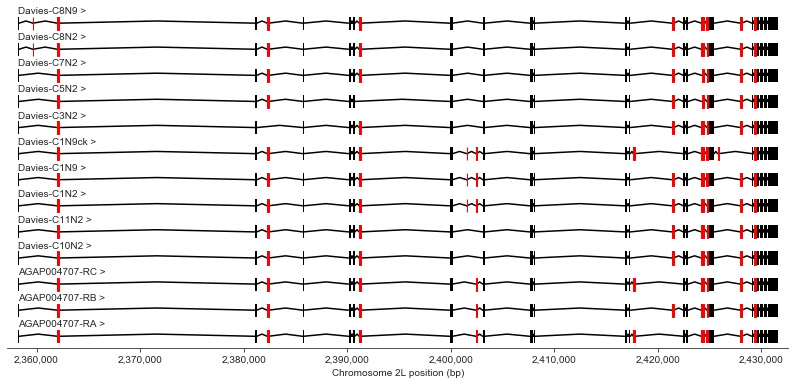

In [7]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_vgsc_combined, chrom, start-1000, stop+1000, highlight_exons=highlight_exons)

Let's work through the gene in detail, taking a few exons at a time. In the plots below, the text **above** the exons (e.g., "3 (156)") show the index of the exon within the transcript (e.g., 3rd exon) and the exon length (e.g., 156 bp long). The text **within** the exons shows the exon number **according to Davies et al.** supplementary table S1, along with a lower-case letter if the exon corresponds to a variable sequence previously identified in *Drosophila* (for a review of *vgsc* studies across insect species see [Dong et al. (2014)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4484874/)).

In the text below I will refer to exons using the exon numbering according to Davies et al. table S1.

### Exons 1, 2 (*j*), 3

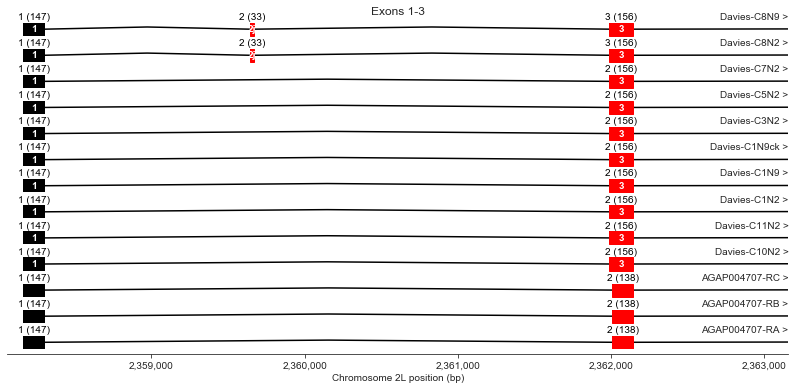

In [8]:
plot_transcripts(geneset_vgsc_combined, chrom, start-100, start+5000,
                 label_transcripts='right', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 1-3')

Exon 2 (also known as optional exon ***j***) is observed in Davies cDNA C8 but not in any AgamP4.4 transcripts. 

Exon 3 is longer in all Davies cDNAs (156 bp) than the AgamP4.4 transcripts (138 bp).

### Exons 4-6

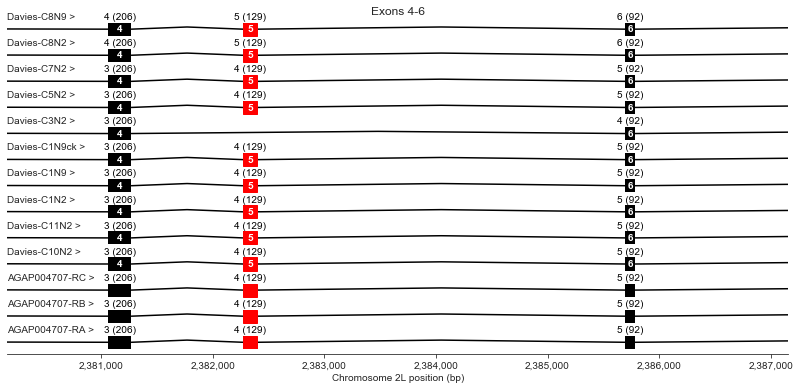

In [9]:
plot_transcripts(geneset_vgsc_combined, chrom, start+22000, start+29000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 4-6')

Exon 5 is not present in Davies cDNA C3. Davies et al. mention that this exon is also optional in the German cockroach (*Blattella germanica*) but should render the channel non-functional because it would eliminate a key region of the voltage sensor.

### Exons 7-10

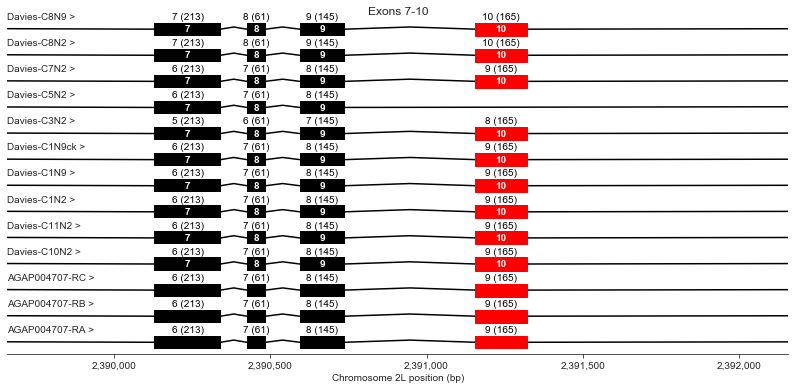

In [10]:
plot_transcripts(geneset_vgsc_combined, chrom, start+31500, start+34000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 7-10')

Exon 10 is missing in Davies cDNA C5. Davies et al. state this should also render the channel non-functional because it would eliminate a key region of the channel pore.

### Exons 11 (*i*+), 12, 13 (*a*), 14

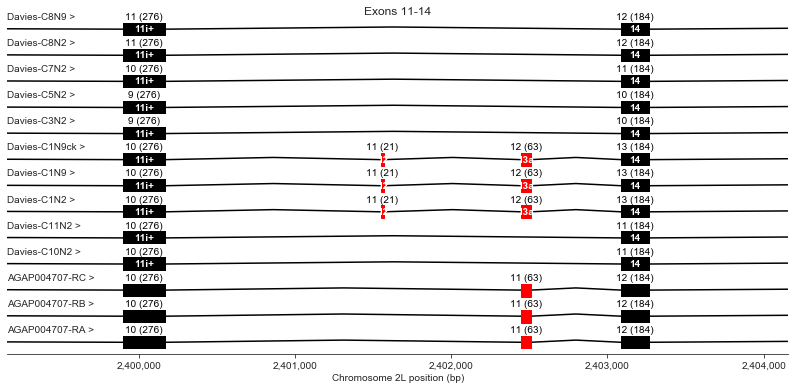

In [11]:
plot_transcripts(geneset_vgsc_combined, chrom, start+41000, start+46000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 11-14')

Exon 12 is present in Davies cDNA C1 but is not in any other transcripts. 

Exon 13 (also known as optional exon ***a***) is present in Davies cDNA C1 and in all AgamP4.4 transcripts but missing from other Davies cDNAs.

### Exons 15-17

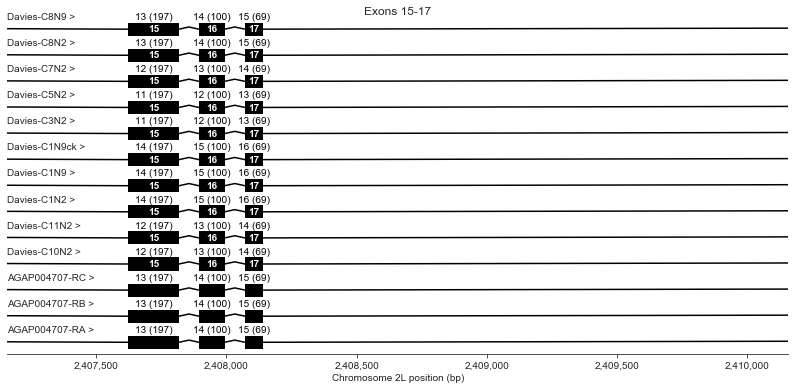

In [12]:
plot_transcripts(geneset_vgsc_combined, chrom, start+49000, start+52000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 15-17')

No splice variation.

### Exons 18 (*b*+), 19, 20 (*c/d*)

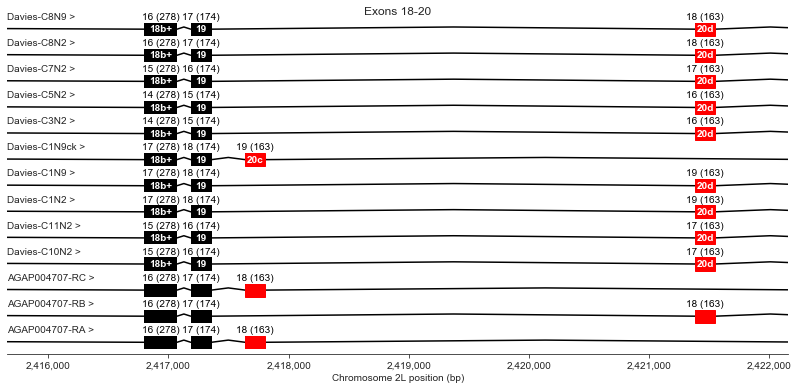

In [13]:
plot_transcripts(geneset_vgsc_combined, chrom, start+57500, start+64000,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 18-20')

For exon 20, Davies finds alternative exon ***c*** in the genomic sequence but does not observe it in any cDNAs (the "Davies-C1N9ck" transcript is a hypothetical transcript I've invented to represent the alternative splice variants for which Davies et al. only find genomic evidence). Two AgamP4.4 transcripts use exon ***c*** and one uses exon ***d***.

Out of interest, how similar are exons ***c*** and ***d***?

In [14]:
import itertools


def pair_seq_comp(a, b):
    h1 = ''
    h2 = ''
    for x, y in itertools.zip_longest(a, b):
        if x == y:
            s = '<span style="background-color: black; color: white">%s</span>' % x
            h1 += s
            h2 += s
        else:
            if x:
                h1 += x
            if y:
                h2 += y
    from IPython.display import display_html
    html = '<pre>' + h1 + '\n' + h2 + '</pre>'
    display_html(html, raw=True)


In [15]:
import pyfasta
genome = pyfasta.Fasta('data/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa', key_fn=lambda v: v.split()[0])

In [16]:
geneset_davies.query('ID == "20c" and type == "exon"')

,seqid,source,type,start,end,score,strand,phase,ID,Parent
342,2L,Davies et al. (2007),exon,2417637,2417799,-1.0,+,-1,20c,Davies-C1N9ck


In [17]:
geneset_davies.query('ID == "20d" and type == "exon"').head(1)

,seqid,source,type,start,end,score,strand,phase,ID,Parent
344,2L,Davies et al. (2007),exon,2421385,2421547,-1.0,+,-1,20d,Davies-C1N2


In [18]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
# trim stop index by 1 to make DNA sequence a multiple of 3
seq_c_dna = Seq(genome['2L'][2417637-1:2417799-1], generic_dna)
seq_d_dna = Seq(genome['2L'][2421385-1:2421547-1], generic_dna)

In [19]:
pair_seq_comp(seq_c_dna.translate(), seq_d_dna.translate())

L R V F K L A K S W P T L N L L I S I M G R T V G A L G N L T F V L C I I I F I F A V M G M Q L F G K N Y T
 L R V F K L A K S W P T L N L L I S I M G R T M G A L G N L T F V L C I I I F I F A V M G M Q L F G K N Y V

### Exons 21, 22, 23 (*f*+/-), 24 (*h*+/-), 25, 26 

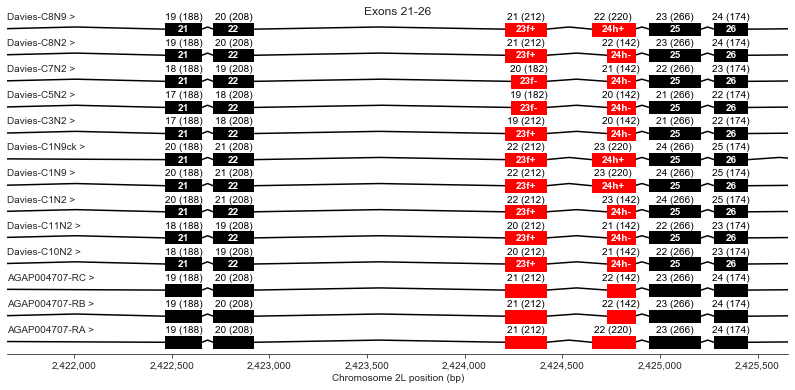

In [20]:
plot_transcripts(geneset_vgsc_combined, chrom, start+63500, start+67500,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exons 21-26')

Exon 23 has an optional region (*f*) which is missing in Davies cDNAs C5 and C7. All AgamP4.4 transcripts include this region.

Exon 24 has an optional region (*h*) which is missing in some Davies cDNAs and in two of the three AgamP4.4 transcripts.

### Exon 27 (*k/l*)

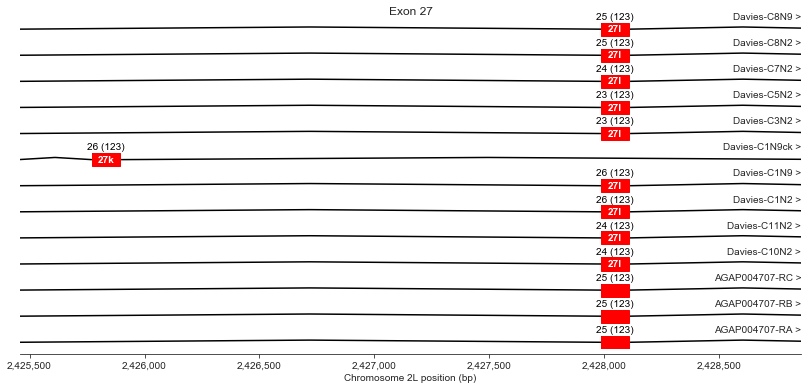

In [21]:
plot_transcripts(geneset_vgsc_combined, chrom, start+67300, start+70700,
                 label_transcripts='right', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons, title='Exon 27')

For exon 27, Davies et al. finding a potential mutually exclusive alternative exon (***k***) within the genomic DNA sequence, although all their cDNAs use exon ***l***, as do all AgamP4.4 transcripts.

Out of interest, how similar are exons ***k***/***l***?

In [22]:
geneset_davies.query('ID == "27k" and type == "exon"')

,seqid,source,type,start,end,score,strand,phase,ID,Parent
482,2L,Davies et al. (2007),exon,2425770,2425892,-1.0,+,-1,27k,Davies-C1N9ck


In [23]:
geneset_davies.query('ID == "27l" and type == "exon"').head(1)

,seqid,source,type,start,end,score,strand,phase,ID,Parent
484,2L,Davies et al. (2007),exon,2427988,2428110,-1.0,+,-1,27l,Davies-C1N2


In [24]:
seq_k_dna = Seq(genome['2L'][2425770-1:2425892], generic_dna)
seq_l_dna = Seq(genome['2L'][2427988-1:2428110], generic_dna)
pair_seq_comp(seq_k_dna.translate(), seq_l_dna.translate())

L S L I N LA A IWV G A AD I P A F RS M R T L R A L R P L R A V S R WE G M R 
V S L I N FV A SLC G A GG I Q A F KT M R T L R A L R P L R A M S R MQ G M R

### Exons 28-33

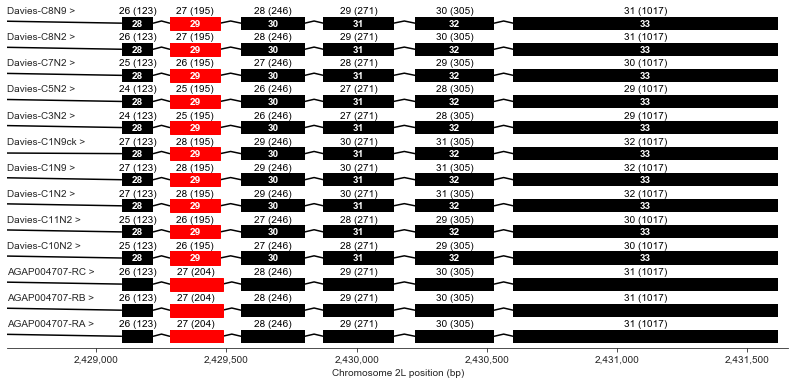

In [25]:
plot_transcripts(geneset_vgsc_combined, chrom, start+70500, start+73500,
                 label_transcripts='left', label_exons=True, label_exon_size=True, 
                 label_cdss='center', highlight_exons=highlight_exons)

Exon 29 is slightly shorter in all of the Davies transcripts than in the AgamP4.4 transcripts.

## Methods

### Exon coordinates

Davies et al. Table S1 gives coordinates for all of the exons they infer, both from the cDNAs and from comparative analysis of the genome sequence. The genomic coordinates are based on some previous version of the *An. gambiae* reference sequence and do not match the current (AgamP3/4) coordinates for the *vgsc* gene. The Davies coordinates look like they're based on a region of the reference sequence that was subsequently inverted, so I transformed the exon coordinates to the AgamP3/4 reference sequence by assuming the AgamP4.4 start coordinate of 2,358,158 for the *vgsc* gene then using the relative exon positions given by Davies. 

I cross-checked the coordinates by comparing the DNA sequence for each exon obtained using the genomic coordinates and the AgamP3/4 reference sequence against the DNA sequence obtained using the mRNA coordinates from Davies et al. Table S1 and the [Davies complete cDNA sequence in GenBank](https://www.ncbi.nlm.nih.gov/nuccore/AM422833.1). For the optional exons, I also compared with the amino acid sequences given in Table S2.

To obtain the best possible concordance between all sources I made the following manual corrections to the exon coordinates:

* I changed the mRNA coordinates for exon 13 to 1645-1707 as the coordinates given in Table S1 are out of sequence and look like a mistaken repetition of the coordinates for exon 15.
* I changed the end coordinate for exon 20c so the translated DNA sequence matched Table S2 and the exon length matched 20d.
* I changed the start and end coordinates for exon 27k so the translated DNA sequence matched Table S2 and the exon length matched 27l.

Here are the AgamP3/4 coordinates for all exons after applying these transformations:

In [26]:
import petl as etl
tbl_davies_exons = (
    etl
    .fromdataframe(geneset_davies)
    .eq('type', 'CDS')
    .cutout('Parent', 'source', 'type', 'score', 'strand')
    .merge(key=('start', 'end'))
    .movefield('ID', 0)
    .rename('ID', 'exon')
    .movefield('seqid', 1)
)
tbl_davies_exons.displayall()

exon,seqid,start,end,phase
1,2L,2358158,2358304,0
2j,2L,2359640,2359672,0
3,2L,2361989,2362144,0
4,2L,2381065,2381270,0
5,2L,2382270,2382398,1
6,2L,2385694,2385785,1
7,2L,2390129,2390341,2
8,2L,2390425,2390485,2
9,2L,2390594,2390738,1
10,2L,2391156,2391320,0


### Inferring transcripts from Davies et al. cDNAs

Davies et al. (Figure 2) report two sets of cDNAs, one set (prefix 'C') covering the first two domains of the protein (exons 1-22) and a second set (prefix 'N') covering the second two domains (exons 23-33). Because they did not have any cDNAs covering the entire *vgsc* gene, they could not infer any complete transcripts. To make it easier to compare the results from Davies et al. with the AgamP4.4 gene annotations, I invented 9 putative transcripts by combining all unique combinations of exon usage observed in the first (C) set of cDNAs with all unique combinations from the second (N) set of cDNAs. I also invented a 10th transcript ("Davies-C1N9ck") to represent the ***c*** and ***k*** exons inferred from the genomic sequence.

Note that there is a bit of inconsistency in Davies et al. between the text and Figure 2C regarding whether exon 10 is also missing in cDNA C3. In Figure 2C it looks like C3 might be missing some other bits as well, and so maybe C3 was incomplete or data quality was poor. To construct the putative transcripts I have assumed C3 is as described in the text, i.e., is missing exon 5 but is otherwise complete.

I formed the transcript IDs by concatenating the cDNA IDs from the first and second regions of the gene. So, i.e., "Davies-C1N2" is a putative transcript assuming exon usage observed in cDNAs C1 and N2.

In [27]:
print('\n'.join(geneset_davies.query('type == "mRNA"').ID.values))

Davies-C1N2
Davies-C3N2
Davies-C5N2
Davies-C7N2
Davies-C8N2
Davies-C10N2
Davies-C11N2
Davies-C1N9
Davies-C8N9
Davies-C1N9ck


## Further reading

* **Davies et al. (2007)** [A comparative study of voltage-gated sodium channels in the Insecta: implications for pyrethroid resistance in Anopheline and other Neopteran species](https://www.ncbi.nlm.nih.gov/pubmed/17433068). Insect Mol Biol.
* **Dong et al. (2014)** [Molecular Biology of Insect Sodium Channels and Pyrethroid Resistance](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4484874/). Insect Biochem Mol Biol.